In [54]:
#importing required libraries and setting matplotlib to inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
%matplotlib inline

In [55]:
#grabbing the dataset
df = pd.read_csv('kc_house_data.csv')

In [56]:
#dropping id and date columns
df.drop(['id', 'date'], axis=1, inplace=True)

In [57]:
#replacing missing data in sqft_basement with column mean
sqft_basement_numerical = df.sqft_basement[df.sqft_basement != '?']
sqft_basement_numerical = sqft_basement_numerical.astype(float)
sqft_basement_numerical_mean = round(sqft_basement_numerical.mean(),1)
df['sqft_basement'] = (df['sqft_basement'].map(lambda x: sqft_basement_numerical_mean if x == '?' else x)).astype(float)

In [58]:
#replacing null values in view with 0
df['view'] = df['view'].fillna(0)

In [59]:
#replacing null values in waterfront with 0
df['waterfront'] = df['waterfront'].fillna(0)

In [60]:
#replacing yr_renovated with categorical column renovated
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df['renovated'] = df.apply(lambda row: 0 if row.yr_renovated < 1 else 1, axis=1)
df.drop('yr_renovated', axis=1, inplace=True)

In [61]:
#dropping lat, long, and zipcode columns
df.drop('lat', axis=1, inplace=True)
df.drop('long', axis=1, inplace=True)
df.drop('zipcode', axis=1, inplace=True)

In [62]:
#stepwise selection function
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [10]:
#initial linear regression with all variables
X = df.drop('price', axis=1)
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=47)
linreg = LinearRegression()
linreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
linreg.score(X_train, y_train)

0.6546452728295744

In [12]:
#for i in df.columns:
 #   df[i] = (df[i] - df[i].mean()) / df[i].std()
#df.head()

In [13]:
X = df.drop('price', axis=1)
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=47)
linreg = LinearRegression()
linreg.fit(X_train,y_train)
linreg.score(X_train, y_train)

0.6546452728295744

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CCEF0C3940>,
      dtype=object)

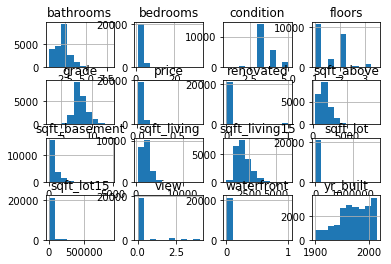

In [63]:
df.hist()

In [15]:
df_sqrt = df
to_sqrt = ['price', 'bedrooms', 'bathrooms', 'waterfront',
          'sqft_living', 'sqft_basement', 'sqft_above', 'sqft_lot15',
         'view', 'renovated']
for i in to_sqrt:
    df_sqrt[i] = np.sqrt(df_sqrt[i])

In [16]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,renovated
0,471.062629,1.732051,1.000000,34.351128,5650,1.0,0.0,0.0,3,7,34.351128,0.000000,1955,1340,75.166482,0.0
1,733.484833,1.732051,1.500000,50.695167,7242,2.0,0.0,0.0,3,7,46.583259,20.000000,1951,1690,87.401373,1.0
2,424.264069,1.414214,1.000000,27.748874,10000,1.0,0.0,0.0,3,6,27.748874,0.000000,1933,2720,89.788641,0.0
3,777.174369,2.000000,1.732051,44.271887,5000,1.0,0.0,0.0,5,7,32.403703,30.166206,1965,1360,70.710678,0.0
4,714.142843,1.732051,1.414214,40.987803,8080,1.0,0.0,0.0,3,8,40.987803,0.000000,1987,1800,86.619859,0.0


In [17]:
X = df_sqrt.drop('price', axis=1)
y = df_sqrt.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=47)
linreg = LinearRegression()
linreg.fit(X_train,y_train)
linreg.score(X_train, y_train)

0.6871400357706552

In [64]:
col_names = df.describe().columns.drop(['price'])
results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
for idx, val in enumerate(col_names):
    print ("Home Sales: price~" + val)
    print ("------------------------------")

    f = 'price~' + val
    model = smf.ols(formula=f, data=df).fit()
    X_new = pd.DataFrame({val: [df[val].min(), df[val].max()]});
    preds = model.predict(X_new)
    results.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1] ])
    print(results[idx+1])

Home Sales: price~bedrooms
------------------------------
['bedrooms', 0.0953497028373066, 127199.51268533265, 122464.44417420312, 0.0]
Home Sales: price~bathrooms
------------------------------
['bathrooms', 0.27657672267607736, 8712.651752670936, 251241.7624951595, 0.0]
Home Sales: price~sqft_living
------------------------------
['sqft_living', 0.49268789904035093, -43988.89219422744, 280.8630143588747, 0.0]
Home Sales: price~sqft_lot
------------------------------
['sqft_lot', 0.008077735099594086, 528258.0465134738, 0.7972846608151651, 5.571622021765821e-40]
Home Sales: price~floors
------------------------------
['floors', 0.06594805661983039, 279114.9959148354, 174809.05327963608, 0.0]
Home Sales: price~waterfront
------------------------------
['waterfront', 0.06985780990281942, 532286.2219943125, 1184928.5040330947, 0.0]
Home Sales: price~view
------------------------------
['view', 0.154839628812666, 496214.77284185647, 189045.80002669396, 0.0]
Home Sales: price~condition
---

In [ ]:
df2 = df_sqrt

In [65]:
X = df.drop('price', axis=1)
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=47)
linreg = LinearRegression()
linreg.fit(X_train,y_train)
linreg.score(X_train, y_train)

0.6546452728295744

In [66]:
result = stepwise_selection(X.drop('renovated', axis=1), y, verbose = True)
print('resulting features:')
print(result)

Add  bedrooms                       with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  view                           with p-value 0.0
Drop sqft_above                     with p-value 0.141698
Add  grade                          with p-value 0.0
Add  yr_built                       with p-value 0.0

C:\Users\sparr\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.



Add  waterfront                     with p-value 4.2404e-210
Add  bathrooms                      with p-value 1.15008e-61
Add  sqft_lot15                     with p-value 3.1101e-24
Add  condition                      with p-value 1.4409e-11
Add  floors                         with p-value 7.74691e-12
Add  sqft_living15                  with p-value 3.14126e-11
resulting features:
['bedrooms', 'sqft_living', 'view', 'grade', 'yr_built', 'waterfront', 'bathrooms', 'sqft_lot15', 'condition', 'floors', 'sqft_living15']


In [67]:
i = 1
while i <= (int(len(df.drop('price', axis=1).columns))):
    linreg = LinearRegression()
    selector = RFE(linreg, n_features_to_select = i)
    selector = selector.fit(X, y) 
    selected_columns = X.columns[selector.support_ ]
    linreg.fit(X[selected_columns],y)
    r_2 = round(linreg.score(X_train[X_train.columns[selector.support_]], y_train), 5)
    r_2a = round(1 - (1-linreg.score(X_train[X_train.columns[selector.support_]], y_train))*(len(y)-1)/(len(y)-X.shape[1]-1), 5)
    print(str(i) + " predictors - " + str(r_2) + " |||| " + str(r_2a))
    print("------- " + str(X_train.columns[selector.support_]))
    i += 1

1 predictors - 0.0586 |||| 0.05794
------- Index(['waterfront'], dtype='object')
2 predictors - 0.48987 |||| 0.48952
------- Index(['waterfront', 'grade'], dtype='object')
3 predictors - 0.4972 |||| 0.49686
------- Index(['waterfront', 'grade', 'renovated'], dtype='object')
4 predictors - 0.52464 |||| 0.52431
------- Index(['waterfront', 'view', 'grade', 'renovated'], dtype='object')
5 predictors - 0.54057 |||| 0.54025
------- Index(['waterfront', 'view', 'condition', 'grade', 'renovated'], dtype='object')
6 predictors - 0.54983 |||| 0.54951
------- Index(['bathrooms', 'waterfront', 'view', 'condition', 'grade', 'renovated'], dtype='object')
7 predictors - 0.55154 |||| 0.55123
------- Index(['bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'renovated'],
      dtype='object')
8 predictors - 0.60926 |||| 0.60898
------- Index(['bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'yr_built', 'renovated'],
      dtype='object')
9 predictors - 0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CCF1C9CA58>,
      dtype=object)

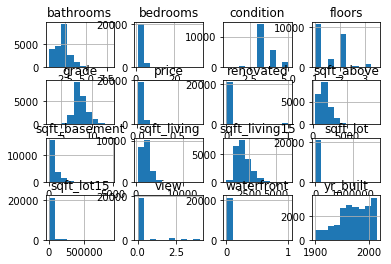

In [68]:
df.hist()

In [70]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [73]:
df.drop(df.index[df['bedrooms'] == 33], inplace=True)

In [74]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

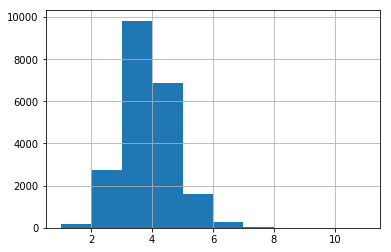

In [75]:
df.bedrooms.hist()

In [76]:
df.drop(df.index[df['bedrooms'] >= 8], inplace=True)

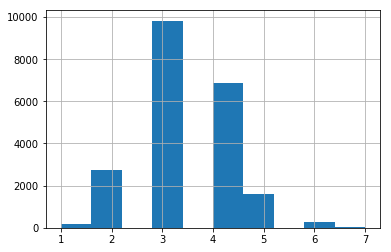

In [77]:
df.bedrooms.hist()

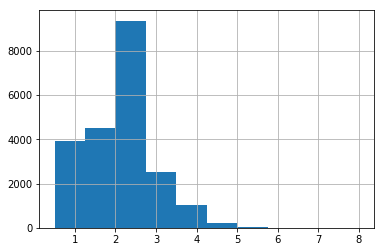

In [78]:
df.bathrooms.hist()

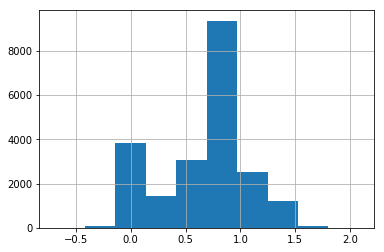

In [82]:
(np.log(df.bathrooms)).hist()

In [83]:
df.bathrooms = np.log(df.bathrooms)

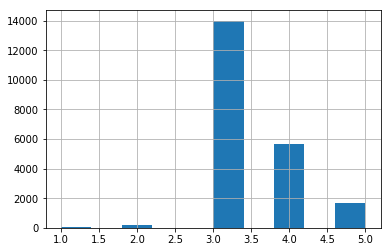

In [85]:
df.condition.hist()

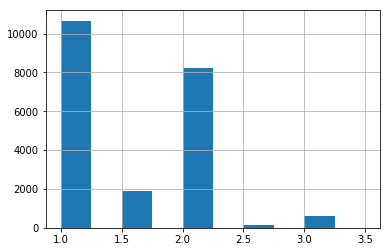

In [91]:
df.floors.hist()

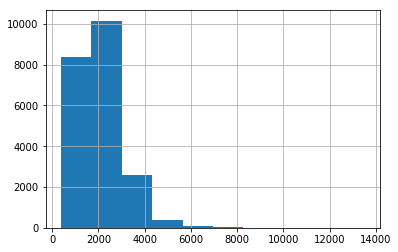

In [94]:
df.sqft_living.hist()

In [104]:
print(len(df[df.sqft_living > 8000]))
print(len(df[df.sqft_living > 6000]))
print(len(df[df.sqft_living > 4000]))

9
67
773


In [105]:
df.drop(df.index[df['sqft_living'] > 4000], inplace=True)

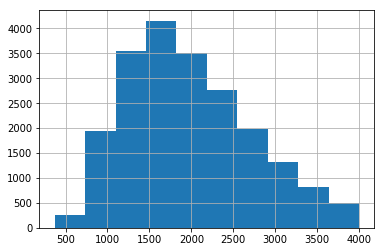

In [106]:
df.sqft_living.hist()

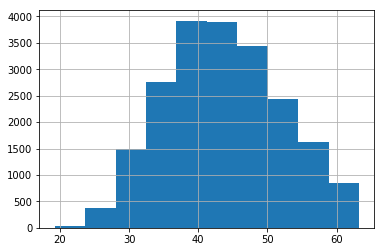

In [108]:
(np.sqrt(df.sqft_living)).hist()

In [109]:
df.sqft_living = np.sqrt(df.sqft_living)

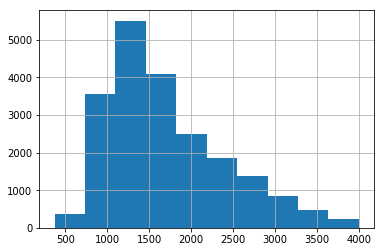

In [110]:
df.sqft_above.hist()

In [111]:
df.sqft_above = np.sqrt(df.sqft_above)

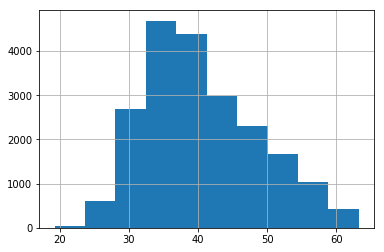

In [112]:
df.sqft_above.hist()

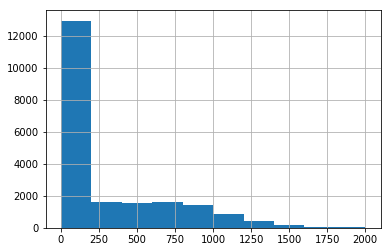

In [113]:
df.sqft_basement.hist()

In [118]:
df['basement'] = df.apply(lambda row: 0 if row.sqft_basement == 0 else 1, axis=1)

In [120]:
df.drop('sqft_basement', axis=1, inplace=True)

In [92]:
X = df.drop('price', axis=1)
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=47)
linreg = LinearRegression()
linreg.fit(X_train,y_train)
linreg.score(X_train, y_train)
i = 1
while i <= (int(len(df.drop('price', axis=1).columns))):
    linreg = LinearRegression()
    selector = RFE(linreg, n_features_to_select = i)
    selector = selector.fit(X, y) 
    selected_columns = X.columns[selector.support_ ]
    linreg.fit(X[selected_columns],y)
    r_2 = round(linreg.score(X_train[X_train.columns[selector.support_]], y_train), 5)
    r_2a = round(1 - (1-linreg.score(X_train[X_train.columns[selector.support_]], y_train))*(len(y)-1)/(len(y)-X.shape[1]-1), 5)
    print(str(i) + " predictors - " + str(r_2) + " |||| " + str(r_2a))
    print("------- " + str(X_train.columns[selector.support_]))
    i += 1

1 predictors - 0.06935 |||| 0.0687
------- Index(['waterfront'], dtype='object')
2 predictors - 0.48893 |||| 0.48858
------- Index(['waterfront', 'grade'], dtype='object')
3 predictors - 0.49862 |||| 0.49827
------- Index(['waterfront', 'grade', 'renovated'], dtype='object')
4 predictors - 0.52442 |||| 0.52409
------- Index(['waterfront', 'view', 'grade', 'renovated'], dtype='object')
5 predictors - 0.53835 |||| 0.53803
------- Index(['waterfront', 'view', 'condition', 'grade', 'renovated'], dtype='object')
6 predictors - 0.54337 |||| 0.54305
------- Index(['bedrooms', 'waterfront', 'view', 'condition', 'grade', 'renovated'], dtype='object')
7 predictors - 0.54347 |||| 0.54316
------- Index(['bedrooms', 'bathrooms', 'waterfront', 'view', 'condition', 'grade',
       'renovated'],
      dtype='object')
8 predictors - 0.54373 |||| 0.54342
------- Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'renovated'],
      dtype='object')
9 predictors -

In [121]:
X = df.drop('price', axis=1)
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=47)
linreg = LinearRegression()
linreg.fit(X_train,y_train)
linreg.score(X_train, y_train)
i = 1
while i <= (int(len(df.drop('price', axis=1).columns))):
    linreg = LinearRegression()
    selector = RFE(linreg, n_features_to_select = i)
    selector = selector.fit(X, y) 
    selected_columns = X.columns[selector.support_ ]
    linreg.fit(X[selected_columns],y)
    r_2 = round(linreg.score(X_train[X_train.columns[selector.support_]], y_train), 5)
    r_2a = round(1 - (1-linreg.score(X_train[X_train.columns[selector.support_]], y_train))*(len(y)-1)/(len(y)-X.shape[1]-1), 5)
    print(str(i) + " predictors - " + str(r_2) + " |||| " + str(r_2a))
    print("------- " + str(X_train.columns[selector.support_]))
    i += 1

1 predictors - 0.03995 |||| 0.03926
------- Index(['waterfront'], dtype='object')
2 predictors - 0.42444 |||| 0.42403
------- Index(['waterfront', 'grade'], dtype='object')
3 predictors - 0.43451 |||| 0.43411
------- Index(['waterfront', 'grade', 'renovated'], dtype='object')
4 predictors - 0.46622 |||| 0.46584
------- Index(['waterfront', 'view', 'grade', 'renovated'], dtype='object')
5 predictors - 0.48035 |||| 0.47997
------- Index(['waterfront', 'view', 'grade', 'renovated', 'basement'], dtype='object')
6 predictors - 0.49769 |||| 0.49732
------- Index(['waterfront', 'view', 'condition', 'grade', 'renovated', 'basement'], dtype='object')
7 predictors - 0.49928 |||| 0.49892
------- Index(['floors', 'waterfront', 'view', 'condition', 'grade', 'renovated',
       'basement'],
      dtype='object')
8 predictors - 0.50221 |||| 0.50185
------- Index(['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'renovated', 'basement'],
      dtype='object')
9 predictors - 0.5

In [122]:
X = df.drop('price', axis=1)
y = np.log(df.price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=47)
linreg = LinearRegression()
linreg.fit(X_train,y_train)
linreg.score(X_train, y_train)
i = 1
while i <= (int(len(df.drop('price', axis=1).columns))):
    linreg = LinearRegression()
    selector = RFE(linreg, n_features_to_select = i)
    selector = selector.fit(X, y) 
    selected_columns = X.columns[selector.support_ ]
    linreg.fit(X[selected_columns],y)
    r_2 = round(linreg.score(X_train[X_train.columns[selector.support_]], y_train), 5)
    r_2a = round(1 - (1-linreg.score(X_train[X_train.columns[selector.support_]], y_train))*(len(y)-1)/(len(y)-X.shape[1]-1), 5)
    print(str(i) + " predictors - " + str(r_2) + " |||| " + str(r_2a))
    print("------- " + str(X_train.columns[selector.support_]))
    i += 1

1 predictors - 0.0173 |||| 0.01659
------- Index(['waterfront'], dtype='object')
2 predictors - 0.43359 |||| 0.43318
------- Index(['waterfront', 'grade'], dtype='object')
3 predictors - 0.44128 |||| 0.44087
------- Index(['waterfront', 'grade', 'renovated'], dtype='object')
4 predictors - 0.47083 |||| 0.47045
------- Index(['waterfront', 'grade', 'renovated', 'basement'], dtype='object')
5 predictors - 0.48865 |||| 0.48829
------- Index(['waterfront', 'condition', 'grade', 'renovated', 'basement'], dtype='object')
6 predictors - 0.50123 |||| 0.50087
------- Index(['waterfront', 'view', 'condition', 'grade', 'renovated', 'basement'], dtype='object')
7 predictors - 0.50707 |||| 0.50671
------- Index(['floors', 'waterfront', 'view', 'condition', 'grade', 'renovated',
       'basement'],
      dtype='object')
8 predictors - 0.51176 |||| 0.5114
------- Index(['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'renovated', 'basement'],
      dtype='object')
9 predictor

In [123]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
       'sqft_living15', 'sqft_lot15', 'renovated', 'basement'],
      dtype='object')

In [144]:
X = df.drop(['price'], axis=1)
y = np.log(df.price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=4)
linreg = LinearRegression()
linreg.fit(X_train,y_train)
linreg.score(X_train, y_train)
i = 1
while i <= (int(len(df.drop('price', axis=1).columns))):
    linreg = LinearRegression()
    selector = RFE(linreg, n_features_to_select = i)
    selector = selector.fit(X, y) 
    selected_columns = X.columns[selector.support_ ]
    linreg.fit(X[selected_columns],y)
    r_2 = round(linreg.score(X_train[X_train.columns[selector.support_]], y_train), 5)
    r_2a = round(1 - (1-linreg.score(X_train[X_train.columns[selector.support_]], y_train))*(len(y)-1)/(len(y)-X.shape[1]-1), 5)
    print(str(i) + " predictors - " + str(r_2) + " |||| " + str(r_2a))
    print("------- " + str(X_train.columns[selector.support_]))
    i += 1

1 predictors - 0.01468 |||| 0.01397
------- Index(['waterfront'], dtype='object')
2 predictors - 0.43532 |||| 0.43491
------- Index(['waterfront', 'grade'], dtype='object')
3 predictors - 0.44353 |||| 0.44312
------- Index(['waterfront', 'grade', 'renovated'], dtype='object')
4 predictors - 0.47233 |||| 0.47195
------- Index(['waterfront', 'grade', 'renovated', 'basement'], dtype='object')
5 predictors - 0.48894 |||| 0.48857
------- Index(['waterfront', 'condition', 'grade', 'renovated', 'basement'], dtype='object')
6 predictors - 0.50145 |||| 0.50109
------- Index(['waterfront', 'view', 'condition', 'grade', 'renovated', 'basement'], dtype='object')
7 predictors - 0.5076 |||| 0.50724
------- Index(['floors', 'waterfront', 'view', 'condition', 'grade', 'renovated',
       'basement'],
      dtype='object')
8 predictors - 0.51249 |||| 0.51214
------- Index(['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'renovated', 'basement'],
      dtype='object')
9 predicto

In [132]:
df.price.describe()

count    2.080000e+04
mean     5.030732e+05
std      2.723739e+05
min      7.800000e+04
25%      3.175000e+05
50%      4.400000e+05
75%      6.170000e+05
max      3.100000e+06
Name: price, dtype: float64

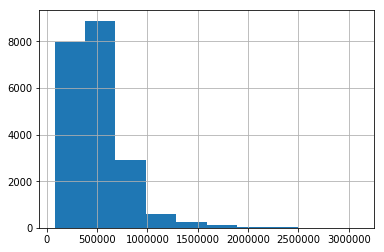

In [138]:
df.price.hist()

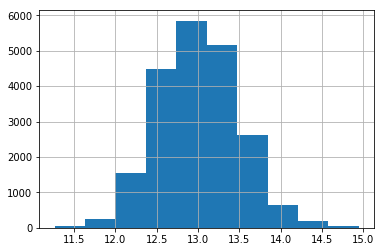

In [139]:
(np.log(df.price)).hist()

In [145]:
df_n = df
for i in df_n.columns:
    df_n[i] = (df_n[i] - df_n[i].mean()) / df_n[i].std()

In [156]:
X = df_n.drop(['price'], axis=1)
y = df_n.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=4)
linreg = LinearRegression()
linreg.fit(X_train,y_train)
linreg.score(X_train, y_train)
i = 1
while i <= (int(len(df.drop('price', axis=1).columns))):
    linreg = LinearRegression()
    selector = RFE(linreg, n_features_to_select = i)
    selector = selector.fit(X, y) 
    selected_columns = X.columns[selector.support_ ]
    linreg.fit(X[selected_columns],y)
    r_2 = round(linreg.score(X_train[X_train.columns[selector.support_]], y_train), 5)
    r_2a = round(1 - (1-linreg.score(X_train[X_train.columns[selector.support_]], y_train))*(len(y)-1)/(len(y)-X.shape[1]-1), 5)
    print(str(i) + " predictors - " + str(r_2) + " |||| " + str(r_2a))
    print("------- " + str(X_train.columns[selector.support_]))
    i += 1

1 predictors - 0.39867 |||| 0.39823
------- Index(['grade'], dtype='object')
2 predictors - 0.49343 |||| 0.49307
------- Index(['grade', 'yr_built'], dtype='object')
3 predictors - 0.54368 |||| 0.54335
------- Index(['sqft_living', 'grade', 'yr_built'], dtype='object')
4 predictors - 0.56657 |||| 0.56626
------- Index(['sqft_living', 'view', 'grade', 'yr_built'], dtype='object')
5 predictors - 0.57246 |||| 0.57215
------- Index(['sqft_living', 'view', 'grade', 'yr_built', 'sqft_living15'], dtype='object')
6 predictors - 0.58022 |||| 0.57992
------- Index(['sqft_living', 'waterfront', 'view', 'grade', 'yr_built',
       'sqft_living15'],
      dtype='object')
7 predictors - 0.58709 |||| 0.58679
------- Index(['sqft_living', 'floors', 'waterfront', 'view', 'grade', 'yr_built',
       'sqft_living15'],
      dtype='object')
8 predictors - 0.59118 |||| 0.59088
------- Index(['sqft_living', 'floors', 'waterfront', 'view', 'grade', 'yr_built',
       'sqft_living15', 'basement'],
      dtype

In [157]:
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 15)
selector = selector.fit(X, y) 
selected_columns = X.columns[selector.support_ ]
linreg.fit(X[selected_columns],y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [162]:
i=0
while i < len(selected_columns):
    print(str(selected_columns[i]) + " " + str(linreg.coef_[i]))
    i += 1

bedrooms -0.05912342676191065
bathrooms 0.04640187198409545
sqft_living 0.17887365970742888
sqft_lot 0.016280353386869575
floors 0.10706888865013522
waterfront 0.10081437109034584
view 0.10961459607470408
condition 0.05564316353415692
grade 0.4525980718736127
sqft_above 0.028315660264371323
yr_built -0.3347654325708907
sqft_living15 0.15914220221902964
sqft_lot15 -0.03721201113368068
renovated 0.025208376930743025
basement 0.07166283995713323
